# Mini-project



## General guidelines

We want to make a typical study of a ML problem.

We're going to use Fashion-MNIST ("*fashion-mnist-reshaped.npz*")  as data set, attempting to classify the pictures correctly.

There are 2 parts in the project:
- use `DecisionTreeClassifier` and PCA from sklearn to classify the data
- make your own multi-class classifier, deriving its updates from scratch
The first part weights more in the total grade than the second one.

In the first part, the goal is to showcase a typical hyper-parameter tuning. We will simulate the fact of having different tasks by restricting ourselves to different dataset size, and comment on how hyper-parameters choice can depend a lot on how much data we have at hand.

General advice: **write clean code**, well factored in functions/classes, for each question, as much as possible.
This will make your code **easier to read and also easier to run!**. You may re-use code in several questions. If it's  well factored, it will be easier to code the next questions.

Tips: you may want to use 
- `sklearn.tree.DecisionTreeClassifier`
- `sklearn.model_selection.train_test_split`
- `sklearn.decomposition.PCA`
- `sklearn.model_selection.cross_validate` 

to lighten your code.

## Part 1: using `sklearn.tree.DecisionTreeClassifier`

## (about 15 points over 20 total)

Decision Trees are powerful methods, however they can easily overfit. The number of parameters in the model essenitially grows like $\sim O(2^{maxDepth})$, i.e. exponentially with the depth of the tree.

### Part 1.1: `Ntrain+Nval=1000, Nvalid=1000, Ntest=10000`

In this part we use this amount of data.
- import the data, split the "train+validation" sets. Keep the test set for the **very** end.
- attempt direct classification using a `sklearn.tree.DecisionTreeClassifier`. Optimize the hyper-parameter `max_depth`. Measure and store the validation accuracy for the best choice of `max_depth`.
Do you fear you may be overfitting ? Explain your answer.
- Now, let's add some PCA as pre-processing. 
    - Using `max_depth=5`, what is the best number of PCA components (nComp_PCA) to keep ? Hint: you may use something like `nComp_range = np.array(list(np.arange(1,50))+[50,100,200,400,783,784])` as the range of nComp_PCA values to be explored.
    - Using `max_depth=12`, what is the best number of PCA components (nComp_PCA) to keep ?
    - Can you explain why this optimal number changes with depth ? 
- Find the best (max_depth, nComp_PCA) pair. 
- Can you explain the behavior of the optimal `max_depth`, let's call it $m*$, with `nComp_PCA`, at **small** `nComp_PCA` ?
- Can you explain the behavior of the optimal `max_depth`, let's call it $m*$, with `nComp_PCA`, at **large** `nComp_PCA` ?
- Measure the cross-validation error for this best pair. Are you surprised with the result?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

import sklearn
import sklearn.model_selection
import sklearn.tree
import sklearn.decomposition
from sklearn.metrics import accuracy_score

import pandas as pd
import seaborn as sns

from IPython.display import display

In [2]:
LoadObject = np.load("../../data/fashion-mnist-reshaped.npz") # please put your data over there so it's easy for me to run your code
# LoadObject = np.load("tools-data/fashion-mnist-reshaped.npz")

linearPictureLength = 28
X = LoadObject['train_images']
y = LoadObject['train_labels']
## we do not use the TEST SET for now:
# Xtest = LoadObject['test_images']
# ytest = LoadObject['test_labels']

In [3]:
print(X.shape, y.shape)

(60000, 784) (60000,)


In [4]:
def sample_split(xdata, ydata, size=1000, valid_size=0.5):
    idx = np.random.choice(range(len(xdata)), size=size, replace=False)
    xsample = xdata[idx]
    ysample = ydata[idx]
    xtrain, xvalid, ytrain, yvalid = sklearn.model_selection.train_test_split(
    xsample, ysample, test_size=valid_size, stratify=ysample)
    
    print(f"Train x and y shape: {xtrain.shape} {ytrain.shape}")
    print(f"Validation x and y shape: {xvalid.shape} {yvalid.shape}")
    
    return xtrain, xvalid, ytrain, yvalid

In [5]:
x11_train, x11_valid, y11_train, y11_valid = sample_split(X, y, size=2000, valid_size=0.5)

Train x and y shape: (1000, 784) (1000,)
Validation x and y shape: (1000, 784) (1000,)


In [6]:
def get_classifier(max_depth=5):
    return sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)

def fit_score(xtrain, ytrain, xvalid, yvalid, max_depths):
    train_scores=[]; valid_scores=[]
    for max_depth in max_depths:
        clf = get_classifier(max_depth)
        clf.fit(xtrain, ytrain)
        train_scores.append(clf.score(xtrain, ytrain))
        valid_scores.append(clf.score(xvalid, yvalid))
    
    return train_scores, valid_scores


In [7]:
max_depths11 = np.arange(start=3, stop=30, step=1)
train_scores11, valid_scores11 = fit_score(x11_train, y11_train, x11_valid, y11_valid, max_depths11)

In [8]:
def plot_hyperparams_scores(hyperparam_name, hyperparams, train_scores, valid_scores, title=None):
    plt.plot(hyperparams, train_scores, label="train")
    plt.plot(hyperparams, valid_scores, label="valid")
    plt.xlabel(hyperparam_name)
    plt.ylabel("accuracy")
    if title : plt.title(title)
    plt.legend()

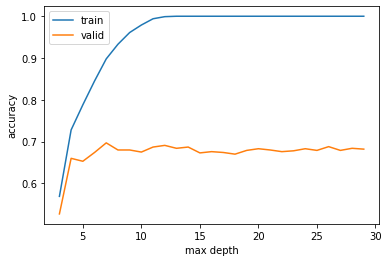

In [9]:
plot_hyperparams_scores("max depth", max_depths11, train_scores11, valid_scores11)

In [10]:
def get_best_hyperparam(hyperparams, train_scores, valid_scores):
    best_idx = np.argmax(valid_scores)
    print(f"Best hyperparameter value: {hyperparams[best_idx]}")
    print(f"Train accuracy: {train_scores[best_idx]}")
    print(f"Validation accuracy: {valid_scores[best_idx]}")
    
    return hyperparams[best_idx]

In [11]:
print("Max depth")
best_max_depth11 = get_best_hyperparam(max_depths11, train_scores11, valid_scores11)

Max depth
Best hyperparameter value: 7
Train accuracy: 0.898
Validation accuracy: 0.697


Starting from around max_depth = 5, the gap between train and validation accuracy grows remarkably.  
At max_depth = 10, train accuracy is almost 1. Validation accuracy almost remains the same.
This is a sign of severe overfitting.

In [12]:
pca_model11 = sklearn.decomposition.PCA()
x11pca_train = pca_model11.fit_transform(x11_train)

pca2_model11 = sklearn.decomposition.PCA(n_components=2)
x11pca2_train = pca2_model11.fit_transform(x11_train)

In [13]:
def pca_fit_score(xtrain, ytrain, xvalid, yvalid, n_components, max_depth=5):
    pca_model = sklearn.decomposition.PCA()
    xpca_train = pca_model.fit_transform(xtrain)
    xpca_valid = pca_model.transform(xvalid)
    
    train_scores=[]; valid_scores=[]
    
    for n_component in n_components:
        reduced_xtrain = xpca_train[:, :n_component]
        reduced_xvalid = xpca_valid[:, :n_component]
        
        clf = get_classifier(max_depth=max_depth)
        clf.fit(reduced_xtrain, ytrain)
        
        train_scores.append(clf.score(reduced_xtrain, ytrain))
        valid_scores.append(clf.score(reduced_xvalid, yvalid))
    
    return train_scores, valid_scores


In [14]:
n_components11 = np.concatenate((np.arange(start=1, stop=50, step=1), np.arange(start=50, stop=700, step=200)))
pca_train_scores11, pca_valid_scores11 = pca_fit_score(x11_train, y11_train, x11_valid, y11_valid, n_components11, max_depth=5)

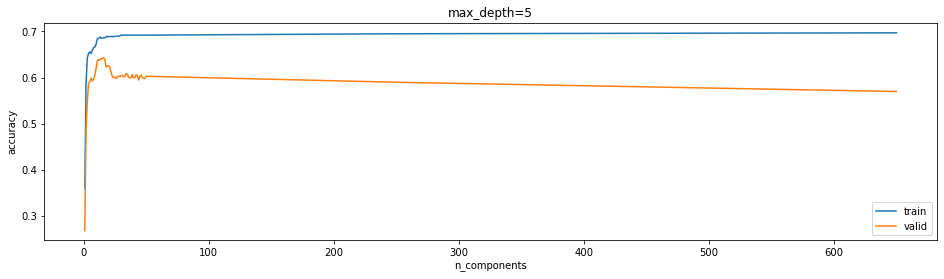

In [15]:
plt.figure(figsize=(16, 4))
plot_hyperparams_scores("n_components", n_components11, pca_train_scores11, pca_valid_scores11, "max_depth=5")

In [16]:
print("n_components for max_depth = 5")
best_ncomponents11 = get_best_hyperparam(n_components11, pca_train_scores11, pca_valid_scores11)

n_components for max_depth = 5
Best hyperparameter value: 16
Train accuracy: 0.686
Validation accuracy: 0.643


In [17]:
pca_train_scores112, pca_valid_scores112 = pca_fit_score(
    x11_train, y11_train, x11_valid, y11_valid, 
    n_components11, max_depth=12
)

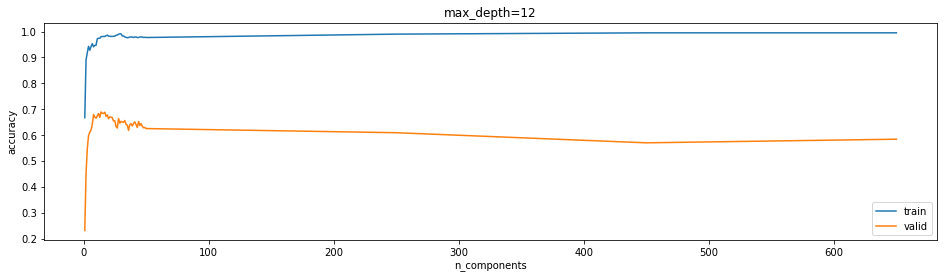

In [18]:
plt.figure(figsize=(16, 4))
plot_hyperparams_scores("n_components", n_components11, pca_train_scores112, pca_valid_scores112, "max_depth=12")

In [19]:
print("n_components for max_depth = 12")
best_ncomponents112 = get_best_hyperparam(n_components11, pca_train_scores112, pca_valid_scores112)

n_components for max_depth = 12
Best hyperparameter value: 14
Train accuracy: 0.98
Validation accuracy: 0.69


As max_depth increases, the decision tree model becomes more expressive.\
Therefore, the number of components may also rise to match the complexity of the model. \
Validation score is better with max_depth = 12. \
However, there are signs of severe overfitting. The gap between train and validation score is huge.

In [20]:
def build_result_df(result_df, train_scores, valid_scores, ncomponents, max_depth):
    new_result = pd.DataFrame(dict(
        train_scores=train_scores,
        valid_scores=valid_scores,
        ncomponents=ncomponents,
    ))
    new_result["max_depth"] = max_depth
    
    return pd.concat((result_df, new_result))

def get_search_result(xtrain, ytrain, xvalid, yvalid, search_max_depths, search_ncomponents):
    result_df = pd.DataFrame()
    
    for search_max_depth in search_max_depths:
        train_scores, valid_scores = pca_fit_score(xtrain, ytrain, xvalid, yvalid, 
        search_ncomponents, max_depth=search_max_depth)
        result_df = build_result_df(result_df, train_scores, valid_scores, search_ncomponents, search_max_depth)
    
    return result_df.reset_index(drop=True)

In [21]:
search_max_depths11 = np.arange(1, 20, 2)
search_ncomponents11 = np.arange(1, 80, 5)
result11 = get_search_result(x11_train, y11_train, x11_valid, y11_valid, search_max_depths11, search_ncomponents11)

display(result11.iloc[:5])

,train_scores,valid_scores,ncomponents,max_depth
0,0.203,0.193,1,1
1,0.196,0.197,6,1
2,0.196,0.197,11,1
3,0.196,0.197,16,1
4,0.196,0.197,21,1


In [22]:
def get_plot_valid_result(search_result):
    valid_result = search_result.pivot(index="max_depth", columns="ncomponents", values="valid_scores")
    plt.figure(figsize=(16, 8))
    sns.heatmap(valid_result, annot=True)
    return valid_result

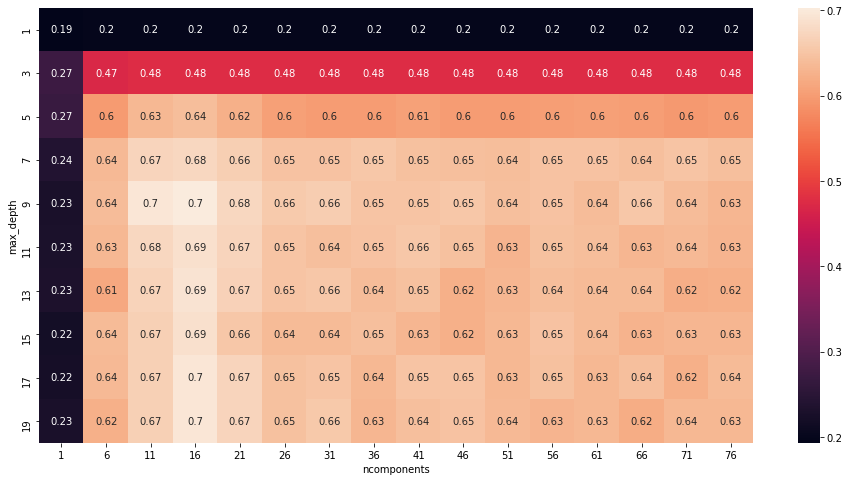

In [23]:
valid_result11 = get_plot_valid_result(result11)

In [24]:
def get_best_result(search_result):
    best_result = search_result.iloc[search_result["valid_scores"].argmax()]
    
    print("Best validation result:")
    display(best_result)
    
    return best_result

In [25]:
best_result11 = get_best_result(result11)

Best validation result:


train_scores     0.898
valid_scores     0.703
ncomponents     16.000
max_depth        9.000
Name: 67, dtype: float64

Train accuracy is 1 or almost, which is an obvious sign of extreme overfitting.\
For small # of components, the best max_depth seems to be in the low and middle range.\
For large # of components, the best max_depth appears to grow along with the # of dimensions.\
\
We can consider # of components to represent data size, and max depth to represent the model complexity.\
When # of components, or the amount of data is low, simpler model having smaller max depth will likely perform better.\
As # of components or quantity of data grows, the model complexity or max depth tends to rise as well.


In [26]:
def cross_validate_best_result(best_result, xtrain, ytrain, xvalid, yvalid):
    xcv = np.concatenate((xtrain, xvalid), axis=0)
    ycv = np.concatenate((ytrain, yvalid), axis=0)
    
    pca_model = sklearn.decomposition.PCA(n_components=int(best_result["ncomponents"]))
    xpca_cv = pca_model.fit_transform(xcv)

    clf = get_classifier(max_depth=int(best_result["max_depth"]))
    cv_result = sklearn.model_selection.cross_validate(clf, xpca_cv, ycv)
    
    print("Cross validation scores: ", cv_result["test_score"])
    print("Average score of cross validation: ", cv_result["test_score"].mean())
    
    return cv_result

In [27]:
best_cv_result11 = cross_validate_best_result(best_result11, x11_train, y11_train, x11_valid, y11_valid)

Cross validation scores:  [0.67   0.71   0.7025 0.65   0.675 ]
Average score of cross validation:  0.6815


The cross validation score is lower than before.\
As expected, this model overfitted and generalizes poorly.

### Part 1.2: `Ntrain+Nval=2000, Nvalid=2000`

If you factored your code decently in the last questions, this should be very easy/fast to do. Ideally, it should be a couple of lines and a single function call. (For the core computation, excluding plots and presentation)
- split the "train+validation" sets. 
- Find the best (max_depth, nComp_PCA) pair. 
- Measure the cross-validation error for this best pair. Are you surprised with the result?


In [28]:
x12_train, x12_valid, y12_train, y12_valid = sample_split(X, y, size=4000, valid_size=0.5)

Train x and y shape: (2000, 784) (2000,)
Validation x and y shape: (2000, 784) (2000,)


In [29]:
search_max_depths12 = np.arange(1, 20, 2)
search_ncomponents12 = np.arange(1, 80, 5)
result12 = get_search_result(x12_train, y12_train, x12_valid, y12_valid, search_max_depths12, search_ncomponents12)

display(result12.iloc[:5])

,train_scores,valid_scores,ncomponents,max_depth
0,0.197,0.1975,1,1
1,0.201,0.1965,6,1
2,0.201,0.1965,11,1
3,0.201,0.1965,16,1
4,0.201,0.1965,21,1


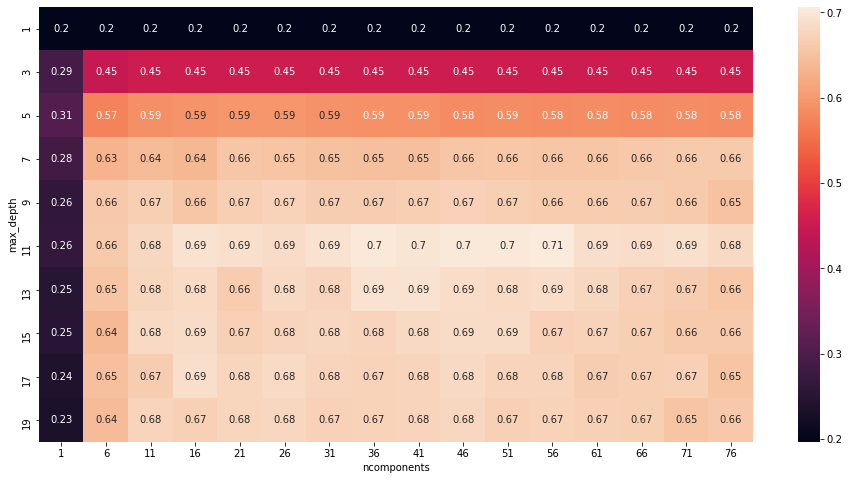

In [30]:
valid_result12 = get_plot_valid_result(result12)

In [31]:
best_result12 = get_best_result(result12)

Best validation result:


train_scores     0.8865
valid_scores     0.7065
ncomponents     56.0000
max_depth       11.0000
Name: 91, dtype: float64

In [32]:
best_cv_result12 = cross_validate_best_result(best_result12, x12_train, y12_train, x12_valid, y12_valid)

Cross validation scores:  [0.71375 0.695   0.71875 0.70125 0.6975 ]
Average score of cross validation:  0.70525


The disparity between train and validation accuracy shrinks slightly compared to section 1.1.\
Validation score improved a little.\

### Part 1.3: `Ntrain+Nval=20000, Nvalid=10000`

If you factored your code decently in the last questions, this should be very easy/fast to do. Ideally, it should be a couple of lines and a single function call. (For the core computation, excluding plots and presentation)
- split the "train+validation" sets.
- Find the best (max_depth, nComp_PCA) pair. 
- Measure the cross-validation error for this best pair. Are you surprised with the result?

**Hint: to save compute time, you can use a smaller hyper-parameter search space, i.e. you can reduce the umber of values explored in your hyper-optimization.**

In [33]:
x13_train, x13_valid, y13_train, y13_valid = sample_split(X, y, size=20000, valid_size=0.5)

Train x and y shape: (10000, 784) (10000,)
Validation x and y shape: (10000, 784) (10000,)


In [34]:
search_max_depths13 = np.arange(1, 20, 5)
search_ncomponents13 = np.arange(1, 100, 10)
result13 = get_search_result(x13_train, y13_train, x13_valid, y13_valid, search_max_depths13, search_ncomponents13)

display(result13.iloc[:5])

,train_scores,valid_scores,ncomponents,max_depth
0,0.1908,0.1893,1,1
1,0.1946,0.1956,11,1
2,0.1946,0.1956,21,1
3,0.1946,0.1956,31,1
4,0.1946,0.1956,41,1


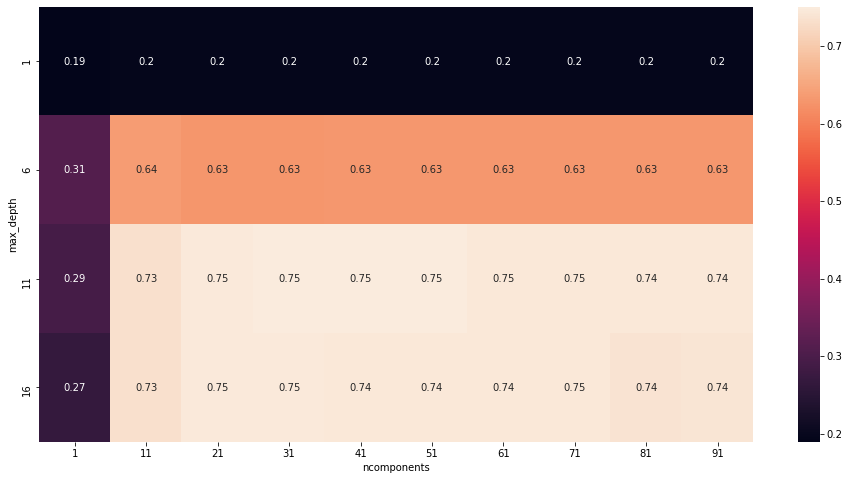

In [35]:
valid_result13 = get_plot_valid_result(result13)

In [36]:
best_result13 = get_best_result(result13)

Best validation result:


train_scores     0.8534
valid_scores     0.7505
ncomponents     41.0000
max_depth       11.0000
Name: 24, dtype: float64

In [37]:
best_cv_result13 = cross_validate_best_result(best_result12, x13_train, y13_train, x13_valid, y13_valid)

Cross validation scores:  [0.74475 0.7675  0.74425 0.749   0.745  ]
Average score of cross validation:  0.7501


The difference between train and validation scores continues to reduce, by a modest amount.\
Besides, validation metric also improves a little.\
Meanwhile, the quantity of data jumps up 10 times compared to section 1.1, and 5 times to section 1.2

### Part 1.4: The test (with `Ntest=10000`)
Use your best model to make a prediction:
- Which model do you prefer, among the 3 "best models" you have found? Why? How confident are you with your choice?
- Using your `Ntest=10000` samples that you saved preciously (and NEVER used), compute the test error. How surprised are you with the result? 
- If you were asked by a client, "what is the level of accuracy you can achieve", what would be your answer ?


In [38]:
Xtest = LoadObject['test_images']
ytest = LoadObject['test_labels']

print(Xtest.shape, ytest.shape)

(10000, 784) (10000,)


In [39]:
def build_fit_score_model(best_result, xtrain, ytrain, xvalid, yvalid):
    
    pca_model = sklearn.decomposition.PCA(n_components=int(best_result["ncomponents"]))
    xtrain_pca = pca_model.fit_transform(xtrain)
    xvalid_pca = pca_model.transform(xvalid)

    clf = get_classifier(max_depth=int(best_result["max_depth"]))
    clf.fit(xtrain_pca, ytrain)
    print(f"Validation accuracy: {clf.score(xvalid_pca, yvalid)}")
    
    return clf, pca_model

In [40]:
model14, pca14 = build_fit_score_model(best_result13, x13_train, y13_train, x13_valid, y13_valid)

Validation accuracy: 0.7512


In [41]:
xtest14 = pca14.transform(Xtest)
print(f"Test accuracy: {model14.score(xtest14, ytest)}")

Test accuracy: 0.7413


1.3 is probably the best model.\
The validation score is higher, and the gap between train and validation accuracy is smaller.\
The test accuracy is almost the same as validation accuracy.\
Therefore, this score should be a reasonable estimate for the generalization performance.

### Part 1.4 - Bonus question : 
- Compute also the cross validation error for the best hyper parameters choice with `N_train=200`
- Plot the cross validation error as a function of ntrain= 200,2000,20000  
- People often say "let's just get more data". How efficient does that does seem to be ? 

Text(0, 0.5, 'CV score')

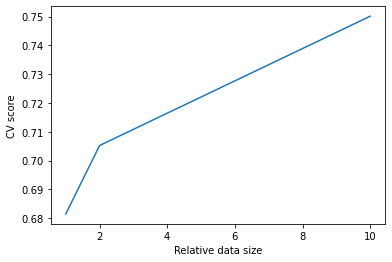

In [42]:
# relative scale of data size 1000, 2000 and 10000
xplot = (1, 2, 10)
yplot=(best_cv_result11["test_score"].mean(), best_cv_result12["test_score"].mean(), best_cv_result13["test_score"].mean())
plt.plot(xplot, yplot)
plt.xlabel("Relative data size")
plt.ylabel("CV score")


From what we have seen, getting more data will bring limited benefit.

## Part 2: make your own classifier !

## (about 5 points over 20 total)

The multi-class percpetron can be implemented this way. 
We denote $K$ the number of classes, $N$ the number of (training) examples, $D$ the dimension of the data (after feature augmentation, at least with a "1" as first component).

The **output** of the network *(not equal to the predicted label)*, can be taken as the **softmax** among the $K$ separating hyperplanes (each hyperplane $\vec{w}_k$ separates class $k$ from the others).
$$ y_k^{(n)} = \text{softmax}\big( (\vec{w}_{k} \cdot \vec{x}^{(n)})_{k=1...K} \big) = \frac{ \exp(  \vec{w}_k\cdot\vec{x}^{(n)}   )}{\sum_\ell \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})}$$
This output can be **interpreted as the probability** that example $x^{(n)}$ belongs to the class $k$, according the classifier's current parameters
Indeed, one can easily check that for any $\vec{x}$, the sum of probabilities is indeed one : $\sum_k y_k = 1$.
The **total output of the network** is a vector $\vec{y}^{(n)} = \begin{pmatrix}y_1^{(n)} \\ y_2^{(n)} \\ .. \\ y_K^{(n)} \end{pmatrix}$ (for the sample number $n$).

The **true labels (ground truth)** of example $\vec{x}^{(n)}$ is then encoded as a one-hot vector, so that if the example is of the second class, it may be written: $\vec{t}^{n} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ .. \\ 0 \end{pmatrix}$. (where $\vec{t}^{(n)}$ or $\vec{t}^{n}$ is for **T**ruth and is shorter to write than $\vec{y}^{GT,(n)}$). More generally, the components $t_{n,k}$ of vector $\vec{t}_n$ may be written using the Kronecker's delta: $t_{n,k} = \delta(k, k_{true}^n)$, where $k_{true}^n$ is the true class of example number $n$.

From now on, **we drop the superscrip $a^{(n)}$ and instead write $a_n$ or just $a$**, when it's clear enough that the quantity $a$ relates to a single example, of generic index $n$. This helps to lighten the notations.

The Loss function that we should use is called the **cross-entropy loss function**, and is:

$$J = \frac1N \sum_n^N H(\vec{t}_{n}, \vec{y}_{n})$$

where the cross-entropy is a non-symmetric function: $$H(\vec{t}_{n}, \vec{y}_{n}) = -\sum_k^K t_{n,k} \log (y_{n,k})$$ 

Make sure you undersand all of the above. Write down the Loss function for the multi-class perceptron. 

### Part 2.1
- What are the parameters of the model ? **How many real numbers is that ?** Count them in terms of $N,K,D, etc$. 
- (3-4 points) **Derive the update steps for the gradient**. (you can get inspiration from TD4.1)
- Some Hints:
    - It is recommended to compute the quantity $\nabla_{w_\ell} y_k$ ($\ell\neq k$) and the quantity $\nabla_{w_k} y_k$. Try to express these simply, by recognizing $y$ when it appears. First treat the two cases separately, then try to unite the two cases in a single mathematical form, using Kronecker's delta : $\delta(i,j)= \{1$ if $i=j$, else $0\}$.
    - When there is a sum $\sum_\ell f(w_\ell)$ and you derive with respect to $w_k$, the output only depends on the term $f(w_k)$ 
    - In the sum above, $\sum_\ell f(w_\ell)$ the index $\ell$ is a "mute" index: you can use any letter for it. Be careful not to use a letter that already exists outside the sum ($\ell$ is like a local variable, don't use the same name for a "global variable" from outside the function !)
    - For any functions $u,v$ that admit derivatives, $\partial_x \frac{u(x)}{v(x)} = \frac{u'(x)v(x)-u(x)v'(x)}{(v(x))^2}$. It extends to $\nabla_x$ without problem.
    - $\nabla_x \exp(u(x)) =  \exp(u(x)) \nabla_x u(x)$.
    - $\frac{a}{1+a} = 1- \frac{1}{1+a}$
    - $\partial_x \log(u(x)) = \frac{u'(x)}{u(x)}$ 
    - If you are too much blocked, you can ask me (via discord, in Private Message) for the solution of $\nabla_{w_k} y_k$ and/or the solution for $\nabla_{w_\ell} y_k$ ($\ell\neq k$).
    - In the end, the update step for the parameters that you should find is : $$ \vec{w}_\ell \mapsto \vec{w}_\ell + \eta \frac1N \sum_n^N \vec{x}_n (\delta_{\ell, k_{true}^n}- y_{\ell,n})$$
    - If you cannot find the equation above, you can just skip this question and use it to make your program.

#### <font color='green'>The derivative of the **cross-entropy loss function** </font>

$$J = \frac1N \sum_n^N H(\vec{t}_{n}, \vec{y}_{n}) = -\frac1N \sum_n^N \sum_k^K t_{n,k} \log (y_{n,k})$$

By replacing $y_{n,k}$ with its expression:

$$J = -\frac1N \sum_n^N \sum_k^K t_{n,k} \log (\frac{ \exp(  \vec{w}_k\cdot\vec{x}^{(n)}   )}{\sum_\ell \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})}) = -\frac1N \sum_n^N \sum_k^K t_{n,k} [ \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)})) - \log({\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})}) ] $$

Either by taking the derivative:

$$ \nabla_{w_\ell} J = -\frac1N \sum_n^N \sum_k^K t_{n,k} \nabla_{w_\ell} [ \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)})) - \log({\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})}) ] $$

We can calculate the two quantities separately $ \nabla_{w_\ell} \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)}))$ and $\nabla_{w_\ell} \log({\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})})$

For the first quantity, we distinguish the two following cases ($\ell\neq k$) and the quantity ($\ell= k$).
- if $\ell\neq k$ then $ \nabla_{w_\ell} \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)})) = 0$
- otherwise, $$ \nabla_{w_\ell} \log (\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))
= \frac{ \nabla_{w_\ell} (\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))}{\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))}
= \frac{ \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})\cdot\vec{x}^{(n)}}{\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))}
= \vec{x}^{(n)}$$

Or finally $$ \nabla_{w_\ell} \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)}))= \delta_{\ell, k}\cdot \vec{x}^{(n)}$$


For the first quantity, we distinguish the two following cases ($\ell\neq k$) and the quantity ($\ell= k$).
- if $\ell\neq k$ then $ \nabla_{w_\ell} \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)})) = 0$
- otherwise, $$ \nabla_{w_\ell} \log (\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))
= \frac{ \nabla_{w_\ell} (\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))}{\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))}
= \frac{ \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})\cdot\vec{x}^{(n)}}{\exp(  \vec{w}_\ell\cdot\vec{x}^{(n)}))}
= \vec{x}^{(n)}$$

Or finally $$ \nabla_{w_\ell} \log (\exp(  \vec{w}_k\cdot\vec{x}^{(n)}))= \delta_{\ell, k}\cdot \vec{x}^{(n)}$$


For the second quantity, we have:
$$\nabla_{w_\ell} \log({\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})})
= \frac {\nabla_{w_\ell} ({\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})})}{\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})}
= \frac {\nabla_{w_\ell} ({ \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})})}{\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})}
= \frac { { \exp(  \vec{w}_\ell\cdot\vec{x}^{(n)})\cdot\vec{x}^{(n)}}}{\sum_i \exp(  \vec{w}_i\cdot\vec{x}^{(n)})}
= y_\ell^{(n)}\cdot\vec{x}^{(n)} $$

$$ \nabla_{w_\ell} J = -\frac1N \sum_n^N \sum_k^K t_{n,k} (\delta_{\ell, k}\cdot \vec{x}^{(n)} - y_\ell^{(n)}\cdot\vec{x}^{(n)})
= -\frac1N \sum_n^N \sum_k^K \delta_{k, k_{true}^n} (\delta_{\ell, k} - y_\ell^{(n)})\cdot\vec{x}^{(n)} 
= -\frac1N \sum_n^N (\sum_k^K \delta_{k, k_{true}^n} \delta_{\ell, k} - \sum_k^K \delta_{k, k_{true}^n} y_\ell^{(n)})\cdot\vec{x}^{(n)} 
$$
As $y_\ell^{(n)}$ does not depend on $k$, we have $$ \sum_k^K \delta_{k, k_{true}^n} y_\ell^{(n)} = y_\ell^{(n)} \cdot \sum_k^K \delta_{k, k_{true}^n} $$
The terms of the last sum are zero everywhere except when $ k = k_{true}^n$, it follows: 
$$ y_\ell^{(n)} \cdot \sum_k^K \delta_{k, k_{true}^n} = y_\ell^{(n)} $$

$$ \nabla_{w_\ell} J = -\frac1N \sum_n^N (\delta_{\ell, k_{true}^n} -  y_\ell^{(n)})\cdot\vec{x}^{(n)} 
$$
Hence, the update step:
$$ \vec{w}_\ell \mapsto \vec{w}_\ell + \eta \frac1N \sum_n^N \vec{x}_n (\delta_{\ell, k_{true}^n}- y_{\ell,n})$$




### Part 2.2
- (3 points) **Think up of all the functions you need to write**, and **put them in a class** (you can get inspiration from the correction of TP3.2) - first write a class skeleton, and **only then, write the methods** inside
- Hints:
    - there may be numerical errors (NaNs) because $\exp(..)$ is too large. You can ease this by noticing the following: for any positive constant $C$, we have $$\frac{ \exp( a_k  )}{\sum_\ell \exp (a_\ell) }  = \frac{C \exp( a_k  )}{C \sum_\ell \exp (a_\ell) }= \frac{\exp( a_k +\log C )}{\sum_\ell \exp (a_\ell +\log C) }$$
    - with this trick, when your arguments in the softmax are too large, you can simply subtract a big constant $\log C$ from its argument, and this will reduce the chances of numerical error, without changing the result. It's a good idea to change the $w $'s with this kind of trick.
    - it's a good idea to define the target labels (ground truth) data in one-hot vectors (as said above), compute them once and for all, and then you never have to compute them again. In practice, you may notice that for an example with label $k_{true}$, then the genreic component number of $k$ of the vector $\vec{t}$ reads: $t_{k} = \delta_{k, k_{true}}$
    - the initial $w$ should be random (not all zeros), preferably, but not too big. A good idea is to have their dispersion be of order $1/D$ at most.
    
For this question, the main goal is to make a theoretically-working, rather clean code, using numpy array-operations (`np.dot`) and not loops, as much as possible. If you manage to do that, you will most likely have a working code (and fast code!)
- (1 point) Test your algorithm on Fashion-MNIST: make a train / validation / test split , fit the model, compute the cross-val error, and the test error. Don't waste time on optimizing hyper-parameters (just take an $\eta$ small enough that you kind of converge. The goal is really to prove that your algorithm does not always crash :)

In [43]:
## remark:
import numpy as np
print(np.exp(100))

2.6881171418161356e+43


In [44]:
"""
def softmax(y):
    exp_y = np.exp(y-900)
    return exp_y / np.sum(exp_y-900,0)
"""

from scipy.special import softmax

def OneHotVector(y,Nc):
    NS = y.shape[0]
    y_true = np.zeros((Nc,y.shape[0])) # true labels
    for i in range(NS):
        y_true[y[i],i] = 1
    return y_true

In [45]:
class MultiClassPerceptronClassifier():

    def __init__(self, classes = 10, eta=0.001, seed=42,maxIter=1000):
        self.eta = eta
        self.seed = seed
        self.classes = classes
        self.maxIter = maxIter
        self.w = None
        
    def initializeWeights(self,D):
        np.random.seed(self.seed)
        wparameters = (np.random.random((self.classes,D))-0.5)/D**0.5
        return wparameters

    def fit(self, Xraw, y_true):
        
        N = Xraw.shape[0]
        X = np.hstack((np.ones((N,1)), Xraw))
        D = X.shape[1]
        w = self.initializeWeights(D)
        t = OneHotVector(y_true,self.classes)

        assert(y_true.shape[0]==N)

        for epoch in range(self.maxIter):
            y = softmax(np.dot(w,X.T))
            w += self.eta*(np.dot((t-y),X)/D)
            Loss = -(np.dot(t,np.log(y).T)).sum()
            if epoch % (self.maxIter//10) ==0 :
                print("epoch ",epoch ,"out of ",self.maxIter,", Loss:", Loss)
                
        self.w = w
        #print('w',w)
        return w
    
    def predict(self,Xraw):
        N = Xraw.shape[0]
        X = np.hstack((np.ones((N,1)), Xraw))
        ypredicted = softmax(np.dot(self.w,X.T))
        return np.argmax(ypredicted,0)
    
    def score(self, X, y):
        ypred = self.predict(X)
        score = accuracy_score(ypred, y)
        return score

In [46]:
print('x11 shape: ',x11_train.shape)
print('y11 shape: ',y11_train.shape)

x11 shape:  (1000, 784)
y11 shape:  (1000,)


In [47]:
# min-max normalization

max_level = x11_train.max()*1.0
n_x11_train = x11_train/ max_level
n_x11_valid = x11_valid/ max_level

In [48]:
clf = MultiClassPerceptronClassifier(eta=0.001) 
w_ = clf.fit(n_x11_train, y11_train)
#x11_train, x11_valid, y11_train, y11_valid

epoch  0 out of  1000 , Loss: 92144.33008766115
epoch  100 out of  1000 , Loss: 94236.14552531572
epoch  200 out of  1000 , Loss: 100927.7114654693
epoch  300 out of  1000 , Loss: 111420.17559753427
epoch  400 out of  1000 , Loss: 124382.41950004174
epoch  500 out of  1000 , Loss: 138884.03384327493
epoch  600 out of  1000 , Loss: 154401.70690843146
epoch  700 out of  1000 , Loss: 170632.43177488563
epoch  800 out of  1000 , Loss: 187385.21828575534
epoch  900 out of  1000 , Loss: 204531.40573815446


In [49]:
ypred = clf.predict(n_x11_valid)
score = clf.score(n_x11_valid, y11_valid)
print("Accuracy score: {}".format(score))

Accuracy score: 0.507
